In [1]:
### import modules
import illustris_python as il
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.patheffects as pe
import matplotlib.transforms as transforms
from matplotlib.gridspec import GridSpec
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.ndimage import gaussian_filter
from scipy.interpolate import interp1d
import scipy.stats
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
from scipy.stats import ks_2samp, anderson_ksamp
import os
import time
import h5py
import rohr_utils as ru 
import random
import six
%matplotlib widget

plt.style.use('fullpage.mplstyle')

zs, times = ru.return_zs_costimes()
times /= 1.0e9 # [Gyr]
scales = 1. / (1.+ zs)


In [2]:
os.chdir('/u/reric/Scripts/')
! pwd

/vera/u/reric/Scripts


In [4]:
def load_grpdict(infname):
    result = {}
    with h5py.File('../Output/TNG50-1_subfindGRP/' + infname, 'r') as f:
        for group_key in f.keys():
            result[group_key] = {}
            for dset_key in f[group_key].keys():
                result[group_key][dset_key] = f[group_key][dset_key][:]
        f.close()
    
    return result

infname = 'central_groups_subfind_TNG50-1_branches.hdf5'
groups_grp_dict = load_grpdict(infname)
groups_grp_dict_keys = list(groups_grp_dict.keys())
halos_snapnum099_grp_dict = load_grpdict('central_subfind_TNG50-1_branches_snapNum099.hdf5')
halos_snapnum067_grp_dict = load_grpdict('central_subfind_TNG50-1_branches_snapNum067.hdf5')
halos_snapnum050_grp_dict = load_grpdict('central_subfind_TNG50-1_branches_snapNum050.hdf5')
halos_snapnum033_grp_dict = load_grpdict('central_subfind_TNG50-1_branches_snapNum033.hdf5')

grp_dicts = [groups_grp_dict,
             halos_snapnum099_grp_dict,
             halos_snapnum067_grp_dict,
             halos_snapnum050_grp_dict,
             halos_snapnum033_grp_dict]


In [5]:
def compute_coldgasCGM(grp_dict):
    """
    Add the CGM cold gas mass and fraction datasets to the grp dict.
    Returns the grp_dict.
    """
    CGMColdGasMass_key = 'SubhaloCGMColdGasMass'
    fCGMColdGas_key = 'SubhaloCGMColdGasFraction'
    for group_key in grp_dict:
        group = grp_dict[group_key]
        group[CGMColdGasMass_key] = np.zeros(group['radii'].shape[0], dtype=group['radii'].dtype) - 1
        group[fCGMColdGas_key] = group[CGMColdGasMass_key].copy()
        for time_index in range(group['radii'].shape[0]):
            radii = group['radii'][time_index]
            r200c = group['HostGroup_R_Crit200'][time_index]
            subhalo_mcgas_shells = group['SubhaloColdGasMassShells'][time_index]
            mask = ((radii > r200c * 0.1) & (radii < r200c))
            subhalo_cgmcgmass = np.sum(subhalo_mcgas_shells[mask])
            group[CGMColdGasMass_key][time_index] = subhalo_cgmcgmass
            group[fCGMColdGas_key][time_index] = subhalo_cgmcgmass / group['HostGroup_M_Crit200'][time_index]
    return grp_dict

for grp_dict in grp_dicts:
    compute_coldgasCGM(grp_dict)

In [ ]:
# compute the number of satellites within each halo matching the following critera:
# 1. Mstar > 10^7 Msun
# 2. fgas = Mgas / Mgas + Mstar > 0.01
# 3. d_sat^host < R_200c
sim = 'TNG50-1'
basePath = ru.ret_basePath(sim)

Nsats_total_key = 'Nsatellites_total'
Nsats_fiducial_key = 'NSatellites_Mstar>1.0e7_fgas>0.01_dsathost<R200c'
Nsats_onlymassive_key = 'NSatellites_Mstar>1.0e9_fgas>0.01_dsathost<R200c'
Nsats_onlySF_key = 'NSatellites_Mstar>1.0e7_SF_dsathost<R200c'
Nsats_keys = [Nsats_total_key,
              Nsats_fiducial_key,
              Nsats_onlymassive_key,
              Nsats_onlySF_key]

for snapNum_i, snapNum in enumerate([99, 67, 50, 33]):

    star_ptn = il.util.partTypeNum('star')
    gas_ptn = il.util.partTypeNum('gas')

    snapNum = 99
    header = ru.loadHeader(basePath, snapNum)
    a = header['Time']
    h = header['HubbleParam']
    boxsize = header['BoxSize'] * a / h
    redshift = header['Redshift']

    Mstar_lolim = 1.0e7
    Mstar_massive_lolim = 1.0e9
    fgas_lolim = 0.01
    sSFR_lolim = -11 + 0.5 * redshift 

    halos = il.groupcat.loadHalos(basePath, snapNum)
    subhalos = il.groupcat.loadSubhalos(basePath, snapNum)

    for group_index, group_key in enumerate(groups_grp_dict):
        group = groups_grp_dict[group_key]

        # initialize the results if this is the first snapNum
        if snapNum_i == 0:
            for Nsat_key in Nsats_keys:
                group[Nsat_key] = np.zeros(group['SnapNum'].size, dtype=int) - 1

        time_index = group['SnapNum'] == snapNum
        haloID = group['HostSubhaloGrNr'][time_index][0]
        r200c = group['HostGroup_R_Crit200'][time_index]

        GroupFirstSub = halos['GroupFirstSub'][haloID]
        GroupLen = halos['GroupNsubs'][haloID]

        GroupPos = halos['GroupPos'][haloID] * a / h

        Satellites_Mstar = subhalos['SubhaloMassInRadType'][GroupFirstSub+1:GroupFirstSub+GroupLen,star_ptn] * 1.0e10 / h
        Satellites_Mgas = subhalos['SubhaloMassType'][GroupFirstSub+1:GroupFirstSub+GroupLen,gas_ptn] * 1.0e10 / h
        Satellites_Pos = subhalos['SubhaloPos'][GroupFirstSub+1:GroupFirstSub+GroupLen] * a / h
        Satellites_SFR = subhalos['SubhaloSFRinRad'][GroupFirstSub+1:GroupFirstSub+GroupLen]
        Satellites_sSFR = np.log10(Satellites_SFR / Satellites_Mstar)
        Satellites_dsathost = ru.mag(Satellites_Pos, GroupPos, boxsize) / r200c

        mask = ((Satellites_Mstar > Mstar_lolim) & 
                (Satellites_Mgas / Satellites_Mstar > fgas_lolim) &
                (Satellites_dsathost < 1.0))
        group[Nsats_fiducial_key][time_index] = mask[mask].size

        mask = ((Satellites_Mstar > Mstar_massive_lolim) & 
                (Satellites_Mgas / Satellites_Mstar > fgas_lolim) &
                (Satellites_dsathost < 1.0))
        group[Nsats_onlymassive_key][time_index] = mask[mask].size

        mask = ((Satellites_Mstar > Mstar_lolim) & 
                (Satellites_sSFR > sSFR_lolim) &
                (Satellites_dsathost < 1.0))
        group[Nsats_onlySF_key][time_index] = mask[mask].size   

        group[Nsats_total_key][time_index] = GroupLen - 1



In [7]:
grp_keys = ['SnapNum', 'CosmicTime', 'HostGroup_M_Crit200',
            'HostGroup_R_Crit200', 'SubhaloMass',
            'Subhalo_Mstar_Rgal', 'Subhalo_Rgal',
            'SubhaloColdGasMass', 'SubhaloHotGasMass', 'SubhaloGasMass',
            'SubhaloCGMColdGasMass', 'SubhaloCGMColdGasFraction']

quench_snap_flag = -99

def create_taudict(grp_dict, snaps, branches_flag=False):
    """ 
    Given the grp_dict and snaps of interest, rearrange the grp_dict
    into a 2D array of the datasets at the snaps of interest. 
    snaps should be a list of snapNums, where snapNum -99 
    is the flag to use the quenching_snap.
    Returns the tau_dict.
    """
    # input validation
    if not isinstance(snaps, (list, np.ndarray)):
        snaps = [snaps]

    tau_keys = grp_keys.copy()
    if branches_flag:
        tau_keys.extend(Nsats_keys)
                        
    tauresult = {}
    # begin loop over subhalos
    for group_index, group_key in enumerate(grp_dict):
        group = grp_dict[group_key]
        # if just starting, then initialize the dictionary 
        if group_index == 0:
            tauresult['SubfindID'] = np.zeros(len(grp_dict), dtype=int)
            tauresult['HostSubhaloGrNr'] = np.zeros(len(grp_dict), dtype=int)
            for tau_key in tau_keys:
                for snap in snaps:
                    if snap == quench_snap_flag:
                        tauresult_key = tau_key + '_snapNumQuench'
                        tauresult[tauresult_key] = np.zeros(len(grp_dict),
                                                            dtype=group[tau_key].dtype) - 1
                    else:
                        tauresult_key = tau_key + '_snapNum%03d'%snap
                        tauresult[tauresult_key] = np.zeros(len(grp_dict),
                                                            dtype=group[tau_key].dtype) - 1
                    
        tauresult['SubfindID'][group_index] = group['SubfindID'][0]
        tauresult['HostSubhaloGrNr'][group_index] = group['HostSubhaloGrNr'][0]
        # finish initializing the the result
        # assign the values at z=0, which are always the 0th element in the array
        for tau_key in tau_keys:
            for snap in snaps:
                if snap == quench_snap_flag:
                    tauresult_key = tau_key + '_snapNumQuench'
                    tau_index = group['quenching_snap'] == group['SnapNum']
                    tauresult[tauresult_key][group_index] = group[tau_key][tau_index]
                else:
                    tauresult_key = tau_key + '_snapNum%03d'%snap
                    tau_index = snap == group['SnapNum']
                    tauresult[tauresult_key][group_index] = group[tau_key][tau_index]
            # finish loop over snaps for the grp_key
        # finish grp_keys for the group
    # finish loop over the groups
    return tauresult
    

In [8]:
groups_tau_dict = create_taudict(groups_grp_dict, [99, 67, 50, 33], branches_flag=False)
halos_snapnum099_tau_dict = create_taudict(halos_snapnum099_grp_dict, 99)
halos_snapnum067_tau_dict = create_taudict(halos_snapnum067_grp_dict, 67)
halos_snapnum050_tau_dict = create_taudict(halos_snapnum050_grp_dict, 50)
halos_snapnum033_tau_dict = create_taudict(halos_snapnum033_grp_dict, 33)


In [16]:
figsizewidth  = 6.902 # the textwidth in inches of MNRAS
figsizeratio = 9. / 16.
figsizeheight = figsizewidth * figsizeratio

outdirec = '/u/reric/Figures/ColdPast/'
sim = 'TNG50-1'

In [40]:
snap_tau_dicts = [halos_snapnum099_tau_dict,
                  halos_snapnum067_tau_dict,
                  halos_snapnum050_tau_dict]

snapNums = [99, 67, 50]

result1 = []
result2 = []
percentiles = [16, 50, 84]
binwidth = 0.2 # log[M200c]
for snapNum_i, snapNum in enumerate(snapNums):
    tau_dict = snap_tau_dicts[snapNum_i]

    x_key = 'HostGroup_M_Crit200_snapNum%03d'%snapNum
    y1_key = 'SubhaloCGMColdGasMass_snapNum%03d'%snapNum
    y2_key = 'SubhaloCGMColdGasFraction_snapNum%03d'%snapNum

    y1 = tau_dict[y1_key]
    mask = y1 > 0
    y1 = np.log10(y1[mask])
    x = np.log10(tau_dict[x_key][mask])
    y2 = np.log10(tau_dict[y2_key][mask])

    result1.append(ru.return2dhiststats_dict(x, y1, binwidth, percentiles=percentiles))
    result2.append(ru.return2dhiststats_dict(x, y2, binwidth, percentiles=percentiles))



In [41]:
result2_dict = result2[0]
10.**(result2_dict[16]), 10.**(result2_dict[50])

(array([8.86269976e-03, 5.15880659e-03, 7.05808688e-03, 3.27705534e-03,
        7.41556049e-04, 1.25337443e-03, 4.13374062e-04, 8.84386551e-04,
        9.29172334e-04, 1.33178012e-03, 6.84275838e-04,            nan,
        3.00128582e-04,            nan, 5.83881102e-05]),
 array([2.69564466e-02, 2.41450689e-02, 1.89465070e-02, 1.23523819e-02,
        8.71339300e-03, 6.47434363e-03, 2.68206799e-03, 2.93290667e-03,
        2.62196998e-03, 2.05273509e-03, 9.80816961e-04,            nan,
        3.34769490e-04,            nan, 5.83881102e-05]))

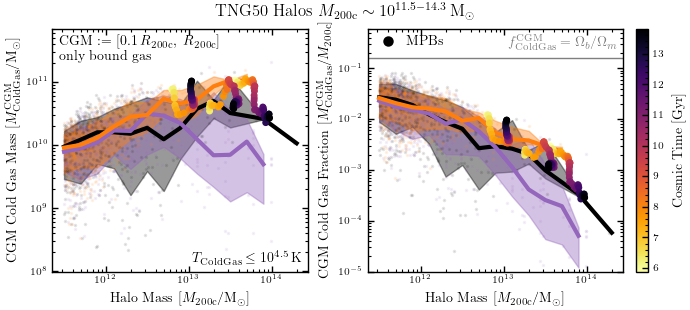

In [82]:
fig, axs = plt.subplots(1, 2, figsize=(figsizewidth, figsizeheight * 0.8))

ax = axs[0]

colors = ['k', 'tab:purple', 'tab:orange']

for snapNum_i, snapNum in enumerate(snapNums):
    tau_dict = snap_tau_dicts[snapNum_i]
    result1_dict = result1[snapNum_i]
    color = colors[snapNum_i]

    y_50s = result1_dict[50]
    mask = y_50s > 0

    y_50s_plot = 10.**(y_50s[mask])
    y_16s_plot = 10.**(result1_dict[16][mask])
    y_84s_plot = 10.**(result1_dict[84][mask])
    x_plot = 10.**(result1_dict['bin_cents'][mask])

    data_points_kwargs = dict(alpha=0.1, ms=1, c=color, zorder=1.9)
    medians_kwargs = dict(ls='-', lw=3, marker='None', c=color, zorder=2)
    sigma_kwargs = dict(color=color, alpha=0.4)

    ax.plot(x_plot, y_50s_plot, **medians_kwargs)
    ax.fill_between(x_plot, y_16s_plot, y_84s_plot, **sigma_kwargs)

    ax.plot(tau_dict['HostGroup_M_Crit200_snapNum%03d'%snapNum], tau_dict['SubhaloCGMColdGasMass_snapNum%03d'%snapNum], **data_points_kwargs)
    
    result2_dict = result2[snapNum_i]

    y_50s_plot = 10.**(result2_dict[50][mask])
    y_16s_plot = 10.**(result2_dict[16][mask])
    y_84s_plot = 10.**(result2_dict[84][mask])
    x_plot = 10.**(result2_dict['bin_cents'][mask])

    axs[1].plot(x_plot, y_50s_plot, **medians_kwargs)
    axs[1].fill_between(x_plot, y_16s_plot, y_84s_plot, **sigma_kwargs)

    axs[1].plot(tau_dict['HostGroup_M_Crit200_snapNum%03d'%snapNum], tau_dict['SubhaloCGMColdGasFraction_snapNum%03d'%snapNum], **data_points_kwargs)
    

group_indices = [1, 6, 23]
min_snap = 50
for group_index in group_indices:
    group = groups_grp_dict[groups_grp_dict_keys[group_index]]
    SnapNum = group['SnapNum']
    subhalo_indices = group['SubfindID'] >= 0
    Subhalo_CGMCGM = group['SubhaloCGMColdGasMass']
    mask = ((SnapNum >= min_snap) & (subhalo_indices) & (Subhalo_CGMCGM > 0))

    plot_every = -1

    x = group['HostGroup_M_Crit200'][mask][::plot_every]
    y1 = Subhalo_CGMCGM[mask][::plot_every]
    y2 = group['SubhaloCGMColdGasFraction'][mask][::plot_every]
    c = group['CosmicTime'][mask][::plot_every]

    sc_kwargs = dict(c=c, cmap='inferno_r', zorder=3, s=16)

    sc = ax.scatter(x, y1, **sc_kwargs)
    sc = axs[1].scatter(x, y2, **sc_kwargs)

#ax.plot(groups_tau_dict['HostGroup_M_Crit200_snapNum099'], groups_tau_dict['SubhaloCGMColdGasMass_snapNum099'], c=colors[0], fillstyle='none', zorder=3)
#ax.plot(groups_tau_dict['HostGroup_M_Crit200_snapNum067'], groups_tau_dict['SubhaloCGMColdGasMass_snapNum067'], c=colors[1], fillstyle='none', zorder=3)
#ax.plot(groups_tau_dict['HostGroup_M_Crit200_snapNum050'], groups_tau_dict['SubhaloCGMColdGasMass_snapNum050'], c=colors[2], fillstyle='none', zorder=3)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(9.9e7, 7.0e11)

ax.set_xlabel(r'Halo Mass $[M_{\rm 200c} / {\rm M_\odot}]$')
ax.set_ylabel(r'CGM Cold Gas Mass $[M_{\rm ColdGas}^{\rm CGM} / {\rm M_\odot}]$')

text = (r'CGM := [$0.1\,R_{\rm 200c},\ R_{\rm 200c}$]' + '\n'
        'only bound gas')
ax.text(0.025, 0.975, text, ha='left', va='top', transform=ax.transAxes, ma='left')
ax.text(0.975, 0.025, r'$T_{\rm ColdGas} \leq 10^{4.5}\, {\rm K}$', ha='right', va='bottom', transform=ax.transAxes)

ax = axs[1]

#ax.plot(groups_tau_dict['HostGroup_M_Crit200_snapNum099'], groups_tau_dict['SubhaloCGMColdGasFraction_snapNum099'], c=colors[0], fillstyle='none')
#ax.plot(groups_tau_dict['HostGroup_M_Crit200_snapNum067'], groups_tau_dict['SubhaloCGMColdGasFraction_snapNum067'], c=colors[1], fillstyle='none')
#ax.plot(groups_tau_dict['HostGroup_M_Crit200_snapNum050'], groups_tau_dict['SubhaloCGMColdGasFraction_snapNum050'], c=colors[2], fillstyle='none')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel(r'Halo Mass $[M_{\rm 200c} / {\rm M_\odot}]$')
ax.set_ylabel(r'CGM Cold Gas Fraction $[M_{\rm ColdGas}^{\rm CGM} / M_{\rm 200c}]$')

ax.plot([], [], 'o', label=r'MPBs')
ax.legend(loc='upper left')

omega_b0 = 0.0486
omega_m0 = 0.3089
ax.axhline(omega_b0 / omega_m0, ls='-', lw=1, zorder=1, marker='None', c='tab:gray')
ax.set_ylim(1.0e-5, 6.0e-1)
ax.text(0.975, 0.975, r'$f_{\rm ColdGas}^{\rm CGM} = \Omega_b / \Omega_m$', ha='right', va='top',
        transform=ax.transAxes, c='tab:gray')

cbar = fig.colorbar(sc, ax=ax, label=r'Cosmic Time [Gyr]')

fig.suptitle(r'TNG50 Halos $M_{\rm 200c} \sim 10^{11.5-14.3}\, {\rm M_\odot}$')

outfname = '%s_CGMCGM-CGMCGf_M200c_allhalos.pdf'%sim
#fig.savefig(outdirec + outfname, bbox_inches='tight')



In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(figsizewidth, figsizeheight * 0.8))

ax = axs[0]

c = groups_tau_dict[Nsats_onlymassive_key+'_snapNum099']

scat = ax.scatter(groups_tau_dict['HostGroup_M_Crit200_snapNum099'], groups_tau_dict['SubhaloCGMColdGasMass_snapNum099'], 
                  c=c, norm=mpl.colors.LogNorm(vmin=np.percentile(c,5), vmax=np.percentile(c,95)))

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(3.0e9, 3.0e11)

ax.set_xlabel(r'Halo Mass $[M_{\rm 200c} / {\rm M_\odot}]$')
ax.set_ylabel(r'CGM Cold Gas Mass $[M_{\rm ColdGas}^{\rm CGM} / {\rm M_\odot}]$')

ax.text(0.025, 0.975, r'CGM := [$0.1\,R_{\rm 200c},\ R_{\rm 200c}$]', ha='left', va='top', transform=ax.transAxes)

ax = axs[1]

scat = ax.scatter(groups_tau_dict['HostGroup_M_Crit200_snapNum099'], groups_tau_dict['SubhaloCGMColdGasFraction_snapNum099'],
                  c=c, norm=mpl.colors.LogNorm(vmin=np.percentile(c,5), vmax=np.percentile(c,95)))

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel(r'Halo Mass $[M_{\rm 200c} / {\rm M_\odot}]$')
ax.set_ylabel(r'CGM Cold Gas Fraction $[M_{\rm ColdGas}^{\rm CGM} / M_{\rm 200c}]$')

omega_b0 = 0.0486
omega_m0 = 0.3089
ax.axhline(omega_b0 / omega_m0, ls='-', lw=1, zorder=1, marker='None', c='tab:gray')
ax.set_ylim(1.0e-5, 6.0e-1)
ax.text(0.975, 0.975, r'$f_{\rm ColdGas}^{\rm CGM} = \Omega_b / \Omega_m$', ha='right', va='top',
        transform=ax.transAxes, c='tab:gray')

text = (r'Satellites with $M_\star^{\rm sat} > 10^9\, {\rm M_\odot}$,' + '\n' +
        r'$f_{\rm gas} = M_{\rm gas}^{\rm sat} / M_\star^{\rm sat} > 1\%$,' + '\n' + 
        r'and $d_{\rm sat}^{\rm host} < R_{\rm 200c}$')

ax.text(0.975, 0.8, text, ha='right', va='top', ma='right', transform=ax.transAxes)

fig.suptitle(r'TNG50 Groups $M_{\rm 200c} \sim 10^{13-14.3}\, {\rm M_\odot}$')

cbar = fig.colorbar(scat, ax=ax, label=r'Number of Satellites')


outfname = '%s_CGMCGM-CGMCGf_M200c_Nsatellties-onlymassive_onlygroups.pdf'%sim
fig.savefig(outdirec + outfname, bbox_inches='tight')